# S12 T01: Aprenentatge Supervisat - Regressions

Observacions:
1.   Notebook desenvolupat utilitzant Google Colab
2.   Repeteixo en aquest notebook el preprocessament del dataset que ja haviem fet en tasques anteriors per tal que el notebook sigui "autocontingut"



In [1]:
# Upgrade Sklearn (in Colab) to latest version 0.24.2
!pip install scikit-learn --upgrade  &> /dev/null

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn import set_config
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone

import time
from tabulate import tabulate
from tqdm.notebook import tqdm
from functools import partial
from tempfile import mkdtemp
from scipy.stats import iqr

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Notebook configuration

# Plots
%matplotlib inline

# Pandas
pd.set_option("display.max_columns", None) # Display all columns of DataFrame

# Pipelines
set_config(display='diagram')  # Display pipelines graphically

# Progress bars
tqdm = partial(tqdm, position=0, leave=True)

# Constants
RS = 123  # Random_state constant value


## Exercici 1
Crea almenys tres models de regressió diferents per intentar predir el millor possible l’endarreriment dels vols (ArrDelay) de DelayedFlights.csv.

### Preprocessament

In [4]:
# Import DataSet directly from Kaggle

# Note: we add '&> /dev/null' to avoid displaying output of terminal commands 

datasetName = 'giovamata/airlinedelaycauses'
zipName = 'airlinedelaycauses.zip'

# Delete files on '/content' folder in Google Colab
!rm /content/*.* &> /dev/null 

!pip install kaggle &> /dev/null

!wget -O kaggle.json https://www.dropbox.com/s/xm28qj0cdfopm6c/kaggle.json?dl=0 &> /dev/null
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json &> /dev/null

!kaggle datasets download $datasetName &> /dev/null

!unzip $zipName

Archive:  airlinedelaycauses.zip
  inflating: DelayedFlights.csv      
  inflating: st99_d00.dbf            
  inflating: st99_d00.shp            
  inflating: st99_d00.shx            


In [5]:
# We create a DataFrame
df = pd.read_csv('/content/DelayedFlights.csv', index_col=0)

# We can delete feature FlightNum as it does not bring any relevant information
# (it is arbitrary, there can be several flights with same number and different destinations)
df.drop(columns=['FlightNum'], inplace=True)

# We delete feature Year (all samples belong to same year 2008)
df.drop(columns=['Year'], inplace=True)

# Renaming of feature DayofMonth as DayOfMonth, for consistency
df.rename(columns = {'DayofMonth': 'DayOfMonth'}, inplace = True)

# Setting type of Month, DayOfMonth, DayOfWeek and CancellationCode as categorical
df[['Month','DayOfMonth','DayOfWeek', 'CancellationCode']] = df[['Month','DayOfMonth','DayOfWeek', 'CancellationCode']].astype('category')

# Setting type of Cancelled and Diverted as boolean
df[['Cancelled','Diverted']] = df[['Cancelled','Diverted']].astype('bool')

df.head()

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Month,DayOfMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,3,4,2003.0,1955,2211.0,2225,WN,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,False,N,False,NaN,NaN,NaN,NaN,NaN
1,1,3,4,754.0,735,1002.0,1000,WN,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,False,N,False,NaN,NaN,NaN,NaN,NaN
2,1,3,4,628.0,620,804.0,750,WN,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,False,N,False,NaN,NaN,NaN,NaN,NaN
4,1,3,4,1829.0,1755,1959.0,1925,WN,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,False,N,False,2.0,0.0,0.0,0.0,32.0
5,1,3,4,1940.0,1915,2121.0,2110,WN,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,4.0,10.0,False,N,False,NaN,NaN,NaN,NaN,NaN


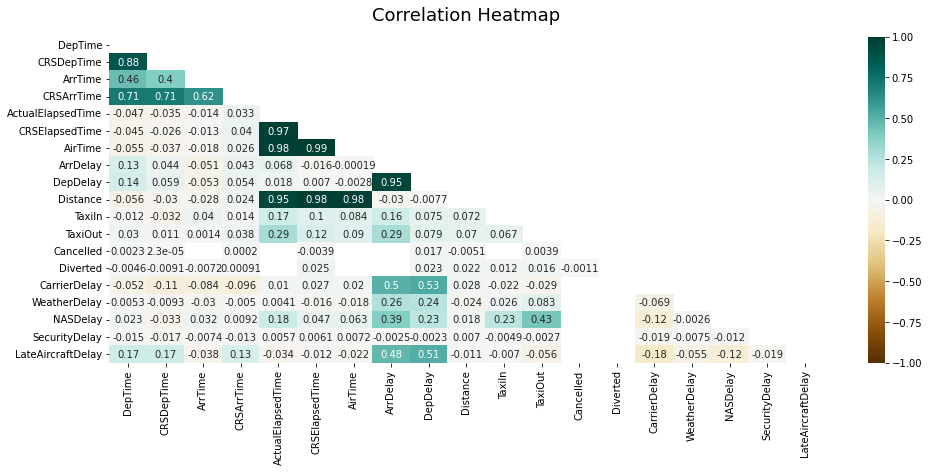

In [6]:
# Correlation Heatmap between features
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

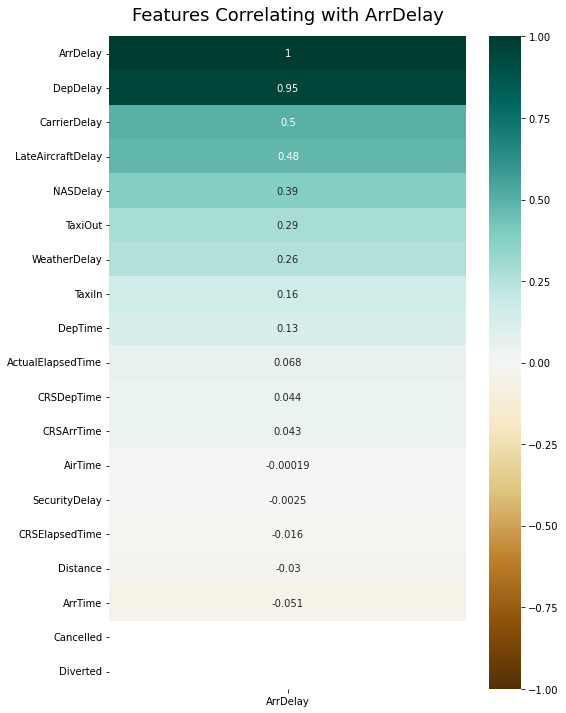

In [7]:
# Correlation of features with target ArrDelay (sorted)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['ArrDelay']].sort_values(by='ArrDelay', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with ArrDelay', fontdict={'fontsize':18}, pad=16);

Veiem que sempre que el vol ha estat cancel·lat (Cancelled==True) o Desviat (Diverted==True) la variable target ArrDelay no està definida (ArrDelay=NaN), com és lògic ja que en aquests casos el vol no arriba a destinació. Per tant podem eliminar les files que tenen Cancelled==True i Diverted==True, i les columnes Cancelled (i CancellationCode) i Diverted

In [8]:
# We check that whenever a glight is cancelled or diverted, ArrDelay is not defined (NaN)

print(f'Number of entries with Cancelled==True and non-NaN ArrDelay: {df[df.Cancelled & ~df.ArrDelay.isna()].shape[0]}')
print(f'Number of entries with Diverted==True and non-NaN ArrDelay: {df[df.Diverted & ~df.ArrDelay.isna()].shape[0]}')

# Therefore we can remove:
# - samples (rows) where Cancelled=True or Diverted=True
# - features (columns) Cancelled, CancellationCode and Diverted

df.drop(df[df.Cancelled  | df.Diverted].index, inplace=True)
df.drop(columns=['Cancelled', 'CancellationCode', 'Diverted'], inplace=True)

Number of entries with Cancelled==True and non-NaN ArrDelay: 0
Number of entries with Diverted==True and non-NaN ArrDelay: 0


Veiem que ArrDelay està fortament correlacionat amb DepDelay (un vol que surt d'origen amb retard és molt probable que arribi a destinació amb retard també). També està bastant correlacionat amb les altres variables de retard (CarrierDelay, LateAircraftDelay, etc) com és lògic. De fet ArrDelay és simplement la suma de tots aquests retards:

$ArrDelay = CarrierDelay + WeatherDelay + NASDelay + SecurityDelay + LateAircraftDelay$

In [9]:
# Checking that ArrDelay - (CarrierDelay + WeatherDelay + NASDelay + SecurityDelay + LateAircraftDelay)
# is always 0 (or NaN when not defined)
foo = df.CarrierDelay + df.WeatherDelay + df.NASDelay + df.SecurityDelay + df.LateAircraftDelay - df.ArrDelay
foo.value_counts(dropna=False)

0.0    1247488
NaN     680883
dtype: int64

D'altra banda, en una situació real, lo interessant seria poder predir quin serà el retard d'arribada **ABANS** que el vol arribi a destinació. Per tant abans de coneixer els valors de CarrierDelay, WeatherDelay, ArrTime, etc. Per això proposem  crear un model només a partir de les variables que es coneixen en el moment en que l'avió s'enlaira i abans que aterri:
Month, DayOfMonth, DayOfWeek, DepTime, DepDelay, CRSDepTime, CRSArrTime, UniqueCarrier, TailNum, CRSElapsedTime, Origin, Dest, Distance, TaxiOut.

D'altra banda, donada la relació:  

$DepDelay = DepTime - CRSDepTime$

podem eliminar una de les dues variables. Eliminem CRSDepTime.


In [10]:
features = ['Month', 'DayOfMonth', 'DayOfWeek', 'DepTime', 'DepDelay', 'CRSArrTime', 'UniqueCarrier', 'TailNum', 'CRSElapsedTime', 'Origin', 'Dest', 'Distance', 'TaxiOut']
target = ['ArrDelay']

df = df[features+target]

Revisem si hi ha missing values:

In [11]:
# Checking missing values
df.isna().sum()

Month             0
DayOfMonth        0
DayOfWeek         0
DepTime           0
DepDelay          0
CRSArrTime        0
UniqueCarrier     0
TailNum           3
CRSElapsedTime    0
Origin            0
Dest              0
Distance          0
TaxiOut           0
ArrDelay          0
dtype: int64

Veiem que només hi ha 3 NaN a la columna TailNum. Eliminem aquestes 3 files.

In [12]:
# Removing 3 rows that have TailNum = NaN
df.drop(df[df.TailNum.isna()].index, inplace=True)

El data set queda així:

In [13]:
display(df.head())
print(f'Number of columns: {df.shape[1]}')
print(f'Number of rows: {df.shape[0]}')
print(f'Features: {features}')
print(f'Target: {target}')

,Month,DayOfMonth,DayOfWeek,DepTime,DepDelay,CRSArrTime,UniqueCarrier,TailNum,CRSElapsedTime,Origin,Dest,Distance,TaxiOut,ArrDelay
0,1,3,4,2003.0,8.0,2225,WN,N712SW,150.0,IAD,TPA,810,8.0,-14.0
1,1,3,4,754.0,19.0,1000,WN,N772SW,145.0,IAD,TPA,810,10.0,2.0
2,1,3,4,628.0,8.0,750,WN,N428WN,90.0,IND,BWI,515,17.0,14.0
4,1,3,4,1829.0,34.0,1925,WN,N464WN,90.0,IND,BWI,515,10.0,34.0
5,1,3,4,1940.0,25.0,2110,WN,N726SW,115.0,IND,JAX,688,10.0,11.0


Number of columns: 14
Number of rows: 1928368
Features: ['Month', 'DayOfMonth', 'DayOfWeek', 'DepTime', 'DepDelay', 'CRSArrTime', 'UniqueCarrier', 'TailNum', 'CRSElapsedTime', 'Origin', 'Dest', 'Distance', 'TaxiOut']
Target: ['ArrDelay']


### Models de regressió

In [14]:
# We split the features in 2 groups, depending on the preprocessing to be performed
# At this moment we consider Month, Day, DayOfWeek as numerical features (not categorical)

# Categorical features
cat_columns = ['TailNum', 'UniqueCarrier', 'Dest', 'Origin']

# Numerical features (all the rest)
num_columns = ['Month', 'DayOfMonth', 'DayOfWeek', 'DepTime', 'DepDelay',
               'CRSArrTime', 'CRSElapsedTime', 'Distance', 'TaxiOut']

print(f"Categorical columns are: {cat_columns}")
print(f"Numerical columns are: {num_columns}")

Categorical columns are: ['TailNum', 'UniqueCarrier', 'Dest', 'Origin']
Numerical columns are: ['Month', 'DayOfMonth', 'DayOfWeek', 'DepTime', 'DepDelay', 'CRSArrTime', 'CRSElapsedTime', 'Distance', 'TaxiOut']


Definim 2 preprocessats diferents segons el tipus de variable.

In [15]:
# Preprocessing/Transformations steps for the pipelines

# Cache folder
cachedir = mkdtemp()

# Transformations for numerical features:
#   - StandardScaler()
num_pipe = Pipeline([('scaler', StandardScaler())],
                    memory=cachedir)

# Transformations for categorical features
#   - One Hot Encoding
cat_pipe = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))],
                    memory=cachedir)

# We combine both transformations
preprocessor = ColumnTransformer(transformers=[
                                               ('num_transf', num_pipe, num_columns),
                                               ('cat_transf', cat_pipe, cat_columns)
                                               ],
                                 verbose=False)

# For some models, the target needs to be a 1D array (not a 2D array).
# So we create this transformation to convert to 1D and we will use it when needed
reshape1D_transf = FunctionTransformer(np.ravel)

Definim 7 models de regressió usant Pipelines i incloent l'etapa de preprocessament. En la majoria de casos deixem els valors de hiperparametres definits per defecte. Però en d'altres hem tingut d'usar algun altre valor (e.g. max_depth en el DecisionTree) perquè amb els valors per defecte trigava molt a convergir.

In [16]:
# Linear Regression
lr_pipeline = Pipeline([
                        ('preprocess', preprocessor), 
                        ('linear_regression', LinearRegression())
                       ])


# Decision Tree
dt_pipeline = Pipeline([
                        ('preprocess', preprocessor), 
                        ('decision_tree', DecisionTreeRegressor(max_depth = 10, random_state=RS))
                       ])

# Random Forest
rf_pipeline = Pipeline([
                        ('preprocess', preprocessor),
                        ('rforest', TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=30,
                                                                                               max_depth=50,
                                                                                               max_features=200,
                                                                                               n_jobs=-1,
                                                                                               random_state=RS),
                            transformer=reshape1D_transf, check_inverse=False))
                       ])

# Lasso Regression
la_pipeline = Pipeline([
                        ('preprocess', preprocessor), 
                        ('lasso_regression', Lasso(random_state=RS))
                       ])

# Ridge Regression
ri_pipeline = Pipeline([
                        ('preprocess', preprocessor), 
                        ('ridge_regression', Ridge(random_state=RS))
                       ])

# ElasticNet
el_pipeline = Pipeline([
                        ('preprocess', preprocessor), 
                        ('elasticnet', ElasticNet(random_state=RS))
                       ])

# List of models
models = [lr_pipeline, dt_pipeline, rf_pipeline, la_pipeline, ri_pipeline, el_pipeline]

## Exercici 2
Compara’ls en base al MSE i al R2.

Separem el dataset en dos: Training set i Test set (no fem servir Validation set perquè tampoc farem un ajust fi dels hiperparametres).

In [17]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df[features], df[target], test_size=0.3, random_state=RS, shuffle=True)

total_size = df.shape[0]
train_size = df_X_train.shape[0]
test_size = df_X_test.shape[0]

print(f'Total size of the dataset: {total_size} samples')
print(f'Check of training set size: {train_size} samples ({100*train_size/total_size:.2f}%)')
print(f'Check of test set size: {test_size} samples ({100*test_size/total_size:.2f}%)')

Total size of the dataset: 1928368 samples
Check of training set size: 1349857 samples (70.00%)
Check of test set size: 578511 samples (30.00%)


Per no repetir codi (DRY) en els següents exercicis, creem 2 funcions:
- **train_test_models** per entrenar tots els models usant el Training Set (mostrejat o no) i evaluar-lo sobre el Test Set (sencer). Mostra per pantalla les mètriques MSE i R2 per al training i test sets, amb la fi de poder comparar els valors i detectar si hi ha overfitting
- **plot_predictions** per a poder veure visualment (gràficament) uns quants valors reals de ArrDelay i les prediccions corresponents per a cada model (previament entrenat). Important: usant *random_state=None* cada cop que executem la funció dibuixa N mostres aleatòries, altrament sempre dibuixarà les mateixes mostres.

In [18]:
def train_test_models(models, df_X_train, df_y_train, df_X_test, df_y_test, train_size=None, verbose=False):
  '''
  Trains all the models (pipelines) in the list "models" using a training set
  and evaluates them using a test set

  Parameters:
    - models: list of models (pipelines) to fit (train)
    - df_X_train and df_y_train: DataFrames (training set) of features and target (ArrDelay)
    - train_size: number of samples to use for training, picked using random sampling.
      Use 'None' to use the full training set (i.e. without sampling)
    - verbose: True to show the progress for debugging (i.e. which models is being processed at each moment)
  
  Returns:
    - models: trained models
    - train_indices: indices of the samples used for training (in case of not using the full training set)
    - train_metrics: dictionary containing MSE and R2 metrics computed on the 
      (sampled) training set. Includes also the training time.
    - test_metrics: dictionary containing MSE and R2 metrics computed on the full test set
  
  Prints:
    - the returned data printed in tabular format
  '''
  
  # Sampling of the training set ('None' for no-sampling i.e. full training set)
  if train_size == None:
    X = df_X_train
    y = df_y_train
    train_indices = X.index.to_list()
  else:
    X = df_X_train.sample(train_size, random_state=RS)
    train_indices = X.index.to_list()
    y = df_y_train.loc[train_indices,:]

  # Initialization of variables
  model_name, mse_train, r2_train, mse_test, r2_test, training_time = [], [], [], [], [], []

  # We iterate over the list of models, showing a progress bar (TQDM)
  for model in tqdm(models):  

    if verbose: print(f"Model: {model.steps[-1][0]}. Training", end="...")

    # Get model name
    model_name.append(model.steps[-1][0])

    # Model training (fitting)
    start = time.time()
    model.fit(X, y)
    stop = time.time()
    training_time.append(stop-start)

    # MSE and R2 metrics evaluated on the (sampled or full) training set
    y_pred = model.predict(X)
    mse_train.append(mean_squared_error(y, y_pred))
    r2_train.append(r2_score(y, y_pred))
    
    if verbose: print(f"Testing", end="...")
    
    # MSE and R2 metrics evaluated on the full test set
    y_pred_test = model.predict(df_X_test)
    mse_test.append(mean_squared_error(df_y_test, y_pred_test))
    r2_test.append(r2_score(df_y_test, y_pred_test))
  
    if verbose: print(f"Done!")

  # Comparison of training and test MSE and R2 metrics
  mse_compare = [f'{100*(j-i)/j:.1f}%' for i,j in zip(mse_train, mse_test)]
  r2_compare = [f'{100*(j-i)/j:.1f}%' for i,j in zip(r2_train, r2_test)]

  # Print summary
  print(f"\n---- Model TrainTesting (Summary) ----")
  print(f"Number of samples (from the training set) used: {train_size:_}")
  print("\n" + tabulate({"Model":model_name,
                  "MSE (Train)": mse_train,
                  "MSE (Test)": mse_test,
                  "diff MSE": mse_compare,
                  "R2 (Train)": r2_train,
                  "R2 (Test)": r2_test,
                  "diff R2": r2_compare,                  
                  "Training Time [s]": training_time
                  },
                  headers="keys"))
  
  train_metrics = {i:{'model':j[0], 'mse':j[1], 'r2':j[2], 'time':j[3]}
                   for i, j in enumerate(zip(model_name, mse_train, r2_train, training_time))}

  test_metrics = {i:{'model':j[0], 'mse':j[1], 'r2':j[2]}
                   for i, j in enumerate(zip(model_name, mse_test, r2_test))}

  return models, train_indices, train_metrics, test_metrics


In [19]:
def plot_predictions(trained_models, df_X, df_y, num_samples=None, random_state=None):
  '''
  Calculates the predictions of a dataset using previously trained models
  and plots them together with the actual value of ArrDelay, for visual comparison.

  Parameters:
    - trained_models: list of models (pipelines) already trained
    - df_X and df_y: DataFrames of features (X) and target ArrDelay (y)
    - num_samples: Integer. Number of samples to predict and plot.
      Use 'None' to use the full dataset (i.e. no sampling)
    - random_state: Integer (to plot same samples at each runtime) 
      or None (to plot different samples at each runtime)
  
  Plots:
    - the actual target values and the predicted values for each model
  '''

  # Random sampling of the dataset ('None' for no-sampling, i.e. full dataset)
  if num_samples == None:
    X = df_X
    y = df_y
  else:
    X = df_X.sample(num_samples, random_state=random_state)
    y = df_y.loc[X.index.to_list(),:]

  # We create a DataFrame with the actual value of ArrDelay
  df_plot = pd.DataFrame()
  df_plot['Actual ArrDelay'] = y['ArrDelay']
  
  # We iterate over the list of models
  # and add to the DataFrame a new column with the ArrDelay prediction for each model
  for model in trained_models:
    y_pred = model.predict(X)
    df_plot[model.steps[-1][0] + ' prediction'] = y_pred

  df_plot.plot(kind='bar',figsize=(25,9))
  plt.title('Examples of ArrDelay actual value vs prediction')
  plt.xlabel('Sample index')
  plt.ylabel('ArrDelay')
  plt.show()

In [20]:
models, indices_train, _, _ = train_test_models(models, 
                                                df_X_train, df_y_train, 
                                                df_X_test, df_y_test, 
                                                train_size=100_000, 
                                                verbose=False)

  0%|          | 0/6 [00:00<?, ?it/s]


---- Model TrainTesting (Summary) ----
Number of samples (from the training set) used: 100_000

Model                MSE (Train)    MSE (Test)  diff MSE      R2 (Train)    R2 (Test)  diff R2      Training Time [s]
-----------------  -------------  ------------  ----------  ------------  -----------  ---------  -------------------
linear_regression        100.349       115.797  13.3%           0.970369     0.964127  -0.6%                  6.63915
decision_tree            127.697       158.489  19.4%           0.962293     0.950901  -1.2%                  3.38878
rforest                  252.667       595.618  57.6%           0.925392     0.815481  -13.5%                48.4548
lasso_regression         144.904       147.06   1.5%            0.957212     0.954442  -0.3%                  5.08802
ridge_regression         102.215       113.755  10.1%           0.969818     0.964759  -0.5%                  0.51251
elasticnet               503.745       487.462  -3.3%           0.851253     0

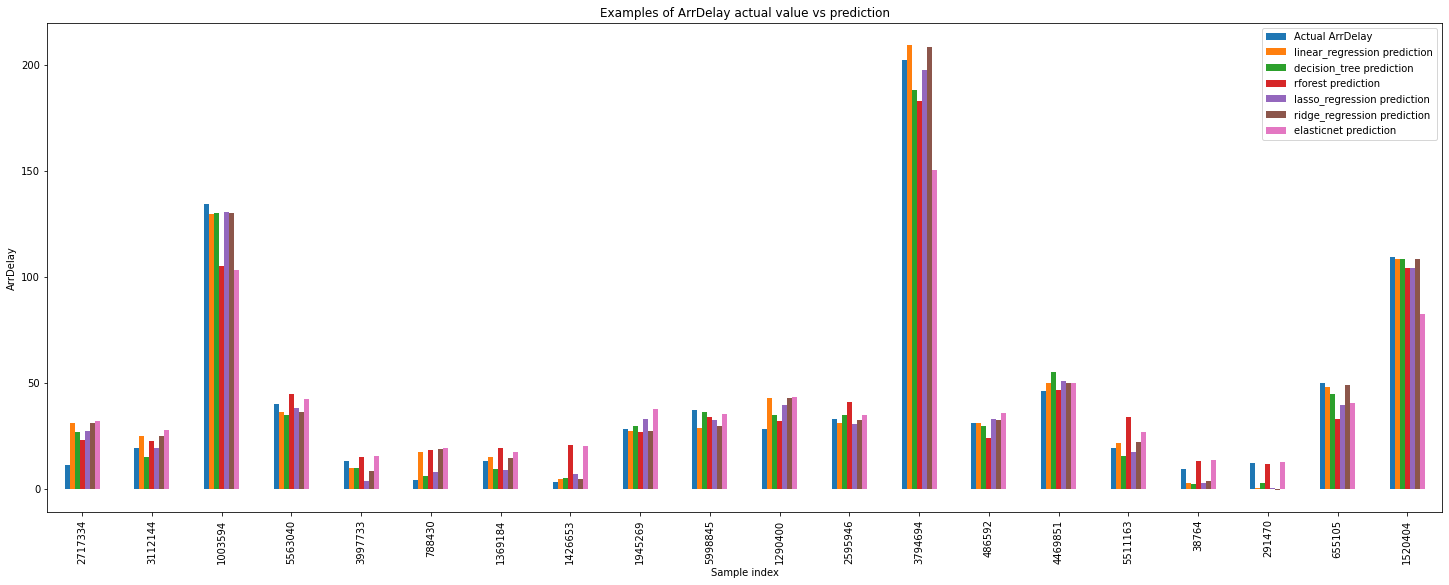

In [21]:
plot_predictions(models, df_X_test, df_y_test, num_samples=20, random_state=None)

Observacions:
- Veiem que les mètriques en el train set i et test set són aproximadament iguals (una mica millors en el train set, com és normal) excepte en el cas del RandomForest on hi ha overfitting.
- RandomForest presenta un rendiment per sota de la resta amb un temps de training molt més gran. Necesitaria un ajust dels hiperparámetres.
- ElasticNet també presenta un rendiment més dolent que la resta. Necessitaria algun ajustament dels hiperparàmetres ja que seria esperable un rendiment com a minim semblant al de Lasso o Ridge.

## Exercici 3
Entrena’ls utilitzant els diferents paràmetres que admeten.

Intentarem millorar el resultat modificant alguns dels paràmetres que permet cada model. Fem una còpia utilitzant "clone" per no sobreescriure els models que ja hem entrenat.

In [22]:
# "Clone" does a deep copy of the model in an estimator without actually copying attached data. 
# It yields a new estimator with the SAME parameters that has NOT been fitted on any data.
models2 = clone(models)

# We try new values for the hyperparameters of each model
# [lr_pipeline, dt_pipeline, rf_pipeline, nn_pipeline, la_pipeline, ri_pipeline, el_pipeline]

# Linear Regression - models2[0]
# No changes. We keep the same parameters.

# Decision Tree - models2[1]
models2[1].set_params(decision_tree__criterion="friedman_mse",
                       decision_tree__max_depth=10);

# Random Forest - models2[2]
models2[2].set_params(rforest__regressor__n_estimators=20,
                      rforest__regressor__max_depth=10,
                      rforest__regressor__max_features=4000);

# Lasso Regression - models2[3]
# No changes. We keep the same parameters.

# Ridge Regression - models2[4]
# No changes. We keep the same parameters.

# ElasticNet Regression - models2[5]
models2[5].set_params(elasticnet__l1_ratio=0.8);



In [23]:
models2, indices_train2, _, _ = train_test_models(models2, 
                                                  df_X_train, df_y_train, 
                                                  df_X_test, df_y_test, 
                                                  train_size=100_000, verbose=False)

  0%|          | 0/6 [00:00<?, ?it/s]


---- Model TrainTesting (Summary) ----
Number of samples (from the training set) used: 100_000

Model                MSE (Train)    MSE (Test)  diff MSE      R2 (Train)    R2 (Test)  diff R2      Training Time [s]
-----------------  -------------  ------------  ----------  ------------  -----------  ---------  -------------------
linear_regression        100.349       115.797  13.3%           0.970369     0.964127  -0.6%                 6.62733
decision_tree            127.697       158.489  19.4%           0.962293     0.950901  -1.2%                 3.38018
rforest                  123.015       145.59   15.5%           0.963676     0.954897  -0.9%                21.8638
lasso_regression         144.904       147.06   1.5%            0.957212     0.954442  -0.3%                 5.12601
ridge_regression         102.215       113.755  10.1%           0.969818     0.964759  -0.5%                 0.536956
elasticnet               244.002       241.025  -1.2%           0.927951     0.925

Veiem que amb els nous paràmetres que hem usat per als models de DecisionTree, RandomForest i ElasticSearch hem millorat les prediccions obtingudes. 

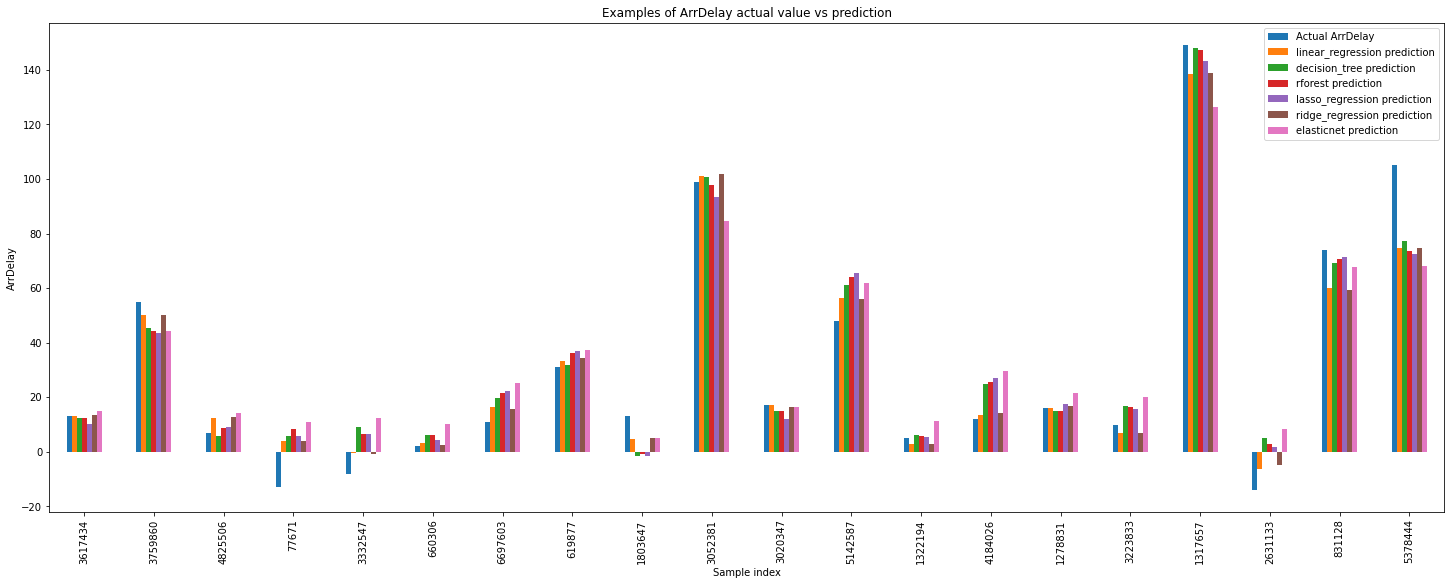

In [24]:
plot_predictions(models2, df_X_test, df_y_test, num_samples=20, random_state=None)

## Exercici 4
Compara el seu rendiment utilitzant l’aproximació traint/test o utilitzant totes les dades (validació interna)

L'aproximació train/test és la que hem utilitzat en els exercicis anteriors.
Aquí utilitzarem CrossValidation per entrenar i evaluar cada model.

In [25]:
def crossvalidate_models(models, df_X_train, df_y_train, sample_size=None, cv=3, verbose=False):
  '''
  Trains and evaluates all the models (pipelines) in the list "models" using cross-validation

  Parameters:
    - models: list of models (pipelines) to fit (train)
    - df_X_train and df_y_train: DataFrames (training set) of features and target (ArrDelay)
    - sample_size: number of samples to use for training, using random sampling.
      Use 'None' to use the full training set (i.e. no sampling)
    - cv
    - verbose: True to show the progress for debugging (i.e. which models is being processed at each moment)
  
  Returns:
    - models: trained models
    - train_indices: indices of the samples used for training (in case of not using the full training set)
    - *train_metrics: dictionary containing average MSE and R2 metrics computed on the 
      (sampled) training set using crossvalidation. Includes also the training time.
    - *test_metrics: dictionary containing MSE and R2 metrics computed on the full test set
  
  Prints:
    - the returned data printed in tabular format
  '''
  
  # Random sampling of the training set (-1 for no-sampling)
  if sample_size == None:
    X = df_X_train
    y = df_y_train
    train_indices = X.index.to_list()
  else:
    X = df_X_train.sample(sample_size, random_state=RS)
    train_indices = X.index.to_list()
    y = df_y_train.loc[train_indices,:]


  # Initialization
  model_name, mse_train, r2_train, mse_test, r2_test, training_time = [], [], [], [], [], []

  for model in tqdm(models):  

    if verbose: print(f"Model: {model.steps[-1][0]}. Training", end="...")

    # Get model name
    model_name.append(model.steps[-1][0])

    # Model training and scoring (cross-validation)
    scores = cross_validate(model, X, y, cv=cv, scoring=['r2','neg_mean_squared_error'], return_train_score=True)

    training_time.append(scores['fit_time'].mean())

    # Average MSE and R2 metrics for the training folds and the test/validation folds
    mse_train.append(-scores['train_neg_mean_squared_error'].mean())
    r2_train.append(scores['train_r2'].mean())

    mse_test.append(-scores['test_neg_mean_squared_error'].mean())
    r2_test.append(scores['test_r2'].mean())
    
    if verbose: print(f"Done!")

  mse_compare = [f'{100*(j-i)/j:.1f}%' for i,j in zip(mse_train, mse_test)]
  r2_compare = [f'{100*(j-i)/j:.1f}%' for i,j in zip(r2_train, r2_test)]

  # Print summary
  print(f"\n---- Model CrossValidation (Summary) ----")
  print(f"Total size: {sample_size:_} samples")
  print(f"Number of folds k={cv}")
  print("\n" + tabulate({"Model":model_name,
                  "avg MSE (Train sets)": mse_train,
                  "avg MSE (Test sets)": mse_test,
                  "diff MSE": mse_compare,
                  "avg R2 (Train sets)": r2_train,
                  "avg R2(Test sets)": r2_test,
                  "diff R2": r2_compare,                  
                  "Training Time [s]": training_time
                  },
                  headers="keys"))
  
  train_metrics = {i:{'model':j[0], 'mse':j[1], 'r2':j[2], 'time':j[3]}
                   for i, j in enumerate(zip(model_name, mse_train, r2_train, training_time))}

  test_metrics = {i:{'model':j[0], 'mse':j[1], 'r2':j[2]}
                   for i, j in enumerate(zip(model_name, mse_test, r2_test))}

  return models, train_indices, train_metrics, test_metrics

Fem una còpia dels models per no sobreescriure'ls quan fem el cross-validation.

In [26]:
# "Clone" does a deep copy of the model in an estimator without actually copying attached data. 
# It yields a new estimator with the SAME parameters that has NOT been fitted on any data.
models3 = clone(models2)

In [27]:
models3, train_indices3, _, _ = crossvalidate_models(models3, df_X_train, df_y_train, sample_size=100_000, cv=5, verbose=True)


  0%|          | 0/6 [00:00<?, ?it/s]

Model: linear_regression. Training...Done!
Model: decision_tree. Training...Done!
Model: rforest. Training...Done!
Model: lasso_regression. Training...Done!
Model: ridge_regression. Training...Done!
Model: elasticnet. Training...Done!

---- Model CrossValidation (Summary) ----
Total size: 100_000 samples
Number of folds k=5

Model                avg MSE (Train sets)    avg MSE (Test sets)  diff MSE      avg R2 (Train sets)    avg R2(Test sets)  diff R2      Training Time [s]
-----------------  ----------------------  ---------------------  ----------  ---------------------  -------------------  ---------  -------------------
linear_regression                 98.7131                116.482  15.3%                    0.97085              0.965582  -0.5%                 5.24493
decision_tree                    125.48                  156.712  19.9%                    0.962946             0.953715  -1.0%                 2.63595
rforest                          122.203                 145.40

Obtenim mètriques similars a les que hem tingut fent train/test, però ha trigat considerablement ja que cada model s'ha hagut d'entrenar 5 cops (k=5 folds). En aquest cas disposem de tantes dades (de fet estem utilitzant molt menys de les que disposem per temes de recursos) que és més convenient fer un train/test que un cross-validation, que sol ser més útil quan disposem de poques dades.

## Exercici 5
Realitza algun procés d’enginyeria de variables per millorar-ne la predicció

Per intentar millorar la predicció, utilitzarem una forma diferent per codificar les variables periòdiques (month, day, time).

In [28]:
def time_to_minutes(t):
  '''
  Converts float time values to minutes
   e.g. 1829 float == 18:29 time ==  1109 minutes
  '''
  t = float(t)
  return 60*(t//100)+(t%100)


def to_cyclic(x, cycle):
  '''
  Cyclic encoding of periodic variable x considering its cycle duration
  '''

  sin_x = np.sin(2*np.pi*x/cycle)
  cos_x = np.cos(2*np.pi*x/cycle)

  return sin_x, cos_x

In [29]:
# Note:
# 1. Categorical columns need first to be converted back to numeric using pd.to_numeric()
# 2. Time values need first to be converted to minutes using time_to_minutes()
# 3. max_cycle values used:
#     12 months in 1 year
#     31 days in 1 month
#     7 days in 1 week
#     24*60 minutes minutes in 1 day

df4 = df.copy()

df4['sin_Month'], df4['cos_Month'] = to_cyclic(pd.to_numeric(df4.Month), 12)
df4['sin_DayOfMonth'], df4['cos_DayOfMonth'] = to_cyclic(pd.to_numeric(df4.DayOfMonth), 31)
df4['sin_DayOfWeek'], df4['cos_DayOfWeek'] = to_cyclic(pd.to_numeric(df4.DayOfWeek), 7)
df4['sin_DepTime'], df4['cos_DepTime'] = to_cyclic(df4.DepTime.map(time_to_minutes), 24*60)
df4['sin_CRSArrTime'], df4['cos_CRSArrTime'] = to_cyclic(df4.CRSArrTime.map(time_to_minutes), 24*60)


In [30]:
df.head()

,Month,DayOfMonth,DayOfWeek,DepTime,DepDelay,CRSArrTime,UniqueCarrier,TailNum,CRSElapsedTime,Origin,Dest,Distance,TaxiOut,ArrDelay
0,1,3,4,2003.0,8.0,2225,WN,N712SW,150.0,IAD,TPA,810,8.0,-14.0
1,1,3,4,754.0,19.0,1000,WN,N772SW,145.0,IAD,TPA,810,10.0,2.0
2,1,3,4,628.0,8.0,750,WN,N428WN,90.0,IND,BWI,515,17.0,14.0
4,1,3,4,1829.0,34.0,1925,WN,N464WN,90.0,IND,BWI,515,10.0,34.0
5,1,3,4,1940.0,25.0,2110,WN,N726SW,115.0,IND,JAX,688,10.0,11.0


In [31]:
# We split the features in 2 groups, depending on the preprocessing to be performed
# At this moment we consider Month, Day, DayOfWeek as numerical features (not categorical)

# Categorical features
cat_columns = ['TailNum', 'UniqueCarrier', 'Dest', 'Origin']

# Numerical features (all the rest)
num_columns = ['sin_Month', 'cos_Month', 'sin_DayOfMonth', 'cos_DayOfMonth', 'sin_DayOfWeek',
               'cos_DayOfWeek', 'sin_DepTime', 'cos_DepTime', 'sin_CRSArrTime', 'cos_CRSArrTime',
               'DepDelay', 'CRSElapsedTime', 'Distance', 'TaxiOut']

features = cat_columns + num_columns
target = ['ArrDelay']

print(f"Categorical columns are: {cat_columns}")
print(f"Numerical columns are: {num_columns}")

Categorical columns are: ['TailNum', 'UniqueCarrier', 'Dest', 'Origin']
Numerical columns are: ['sin_Month', 'cos_Month', 'sin_DayOfMonth', 'cos_DayOfMonth', 'sin_DayOfWeek', 'cos_DayOfWeek', 'sin_DepTime', 'cos_DepTime', 'sin_CRSArrTime', 'cos_CRSArrTime', 'DepDelay', 'CRSElapsedTime', 'Distance', 'TaxiOut']


In [32]:
# Transformations for numerical features:
#   - StandardScaler()
num_pipe = Pipeline([('scaler', StandardScaler())],
                    memory=cachedir)

# Transformations for categorical features
#   - One Hot Encoding
cat_pipe = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))],
                    memory=cachedir)

# We combine both transformations
# Old features, that are not included on num_pipe and cat_pipe, will be ignored (droped)
preprocessor = ColumnTransformer(transformers=[
                                               ('num_transf', num_pipe, num_columns),
                                               ('cat_transf', cat_pipe, cat_columns)
                                               ],
                                 remainder='drop',
                                 verbose=False)

In [33]:
# Linear Regression
lr_pipeline4 = Pipeline([
                        ('preprocess', preprocessor), 
                        ('linear_regression', LinearRegression())
                       ])


# Decision Tree
dt_pipeline4 = Pipeline([
                        ('preprocess', preprocessor), 
                        ('decision_tree', DecisionTreeRegressor(max_depth = 10, criterion='friedman_mse', random_state=RS))
                       ])

# Random Forest
rf_pipeline4 = Pipeline([
                        ('preprocess', preprocessor),
                        ('rforest', TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=20,
                                                                                               max_depth=10,
                                                                                               max_features=4000,
                                                                                               n_jobs=-1,
                                                                                               random_state=RS),
                            transformer=reshape1D_transf, check_inverse=False))
                       ])


# Lasso Regression
la_pipeline4 = Pipeline([
                        ('preprocess', preprocessor), 
                        ('lasso_regression', Lasso(random_state=RS))
                       ])

# Ridge Regression
ri_pipeline4 = Pipeline([
                        ('preprocess', preprocessor), 
                        ('ridge_regression', Ridge(random_state=RS))
                       ])

# ElasticNet
el_pipeline4 = Pipeline([
                        ('preprocess', preprocessor), 
                        ('elasticnet', ElasticNet(l1_ratio=0.8, random_state=RS))
                       ])

# List of models
models4 = [lr_pipeline4, dt_pipeline4, rf_pipeline4, la_pipeline4, ri_pipeline4, el_pipeline4]

In [34]:
df_X_train4, df_X_test4, df_y_train4, df_y_test4 = train_test_split(df4[features], df4[target], test_size=0.3, random_state=RS, shuffle=True)

total_size = df4.shape[0]
train_size = df_X_train4.shape[0]
test_size = df_X_test4.shape[0]

print(f'Total size of the dataset: {total_size} samples')
print(f'Check of training set size: {train_size} samples ({100*train_size/total_size:.2f}%)')
print(f'Check of test set size: {test_size} samples ({100*test_size/total_size:.2f}%)')

Total size of the dataset: 1928368 samples
Check of training set size: 1349857 samples (70.00%)
Check of test set size: 578511 samples (30.00%)


In [35]:
models4, indices_train4, _, _ = train_test_models(models4, 
                                                df_X_train4, df_y_train4, 
                                                df_X_test4, df_y_test4, 
                                                train_size=100_000, 
                                                verbose=True)

  0%|          | 0/6 [00:00<?, ?it/s]

Model: linear_regression. Training...Testing...Done!
Model: decision_tree. Training...Testing...Done!
Model: rforest. Training...Testing...Done!
Model: lasso_regression. Training...Testing...Done!
Model: ridge_regression. Training...Testing...Done!
Model: elasticnet. Training...Testing...Done!

---- Model TrainTesting (Summary) ----
Number of samples (from the training set) used: 100_000

Model                MSE (Train)    MSE (Test)  diff MSE      R2 (Train)    R2 (Test)  diff R2      Training Time [s]
-----------------  -------------  ------------  ----------  ------------  -----------  ---------  -------------------
linear_regression        99.6636       115.025  13.4%           0.970571     0.964366  -0.6%                 9.23071
decision_tree           127.494        158.942  19.8%           0.962353     0.950761  -1.2%                 4.29066
rforest                 124.068        146.062  15.1%           0.963365     0.954751  -0.9%                27.5078
lasso_regression      

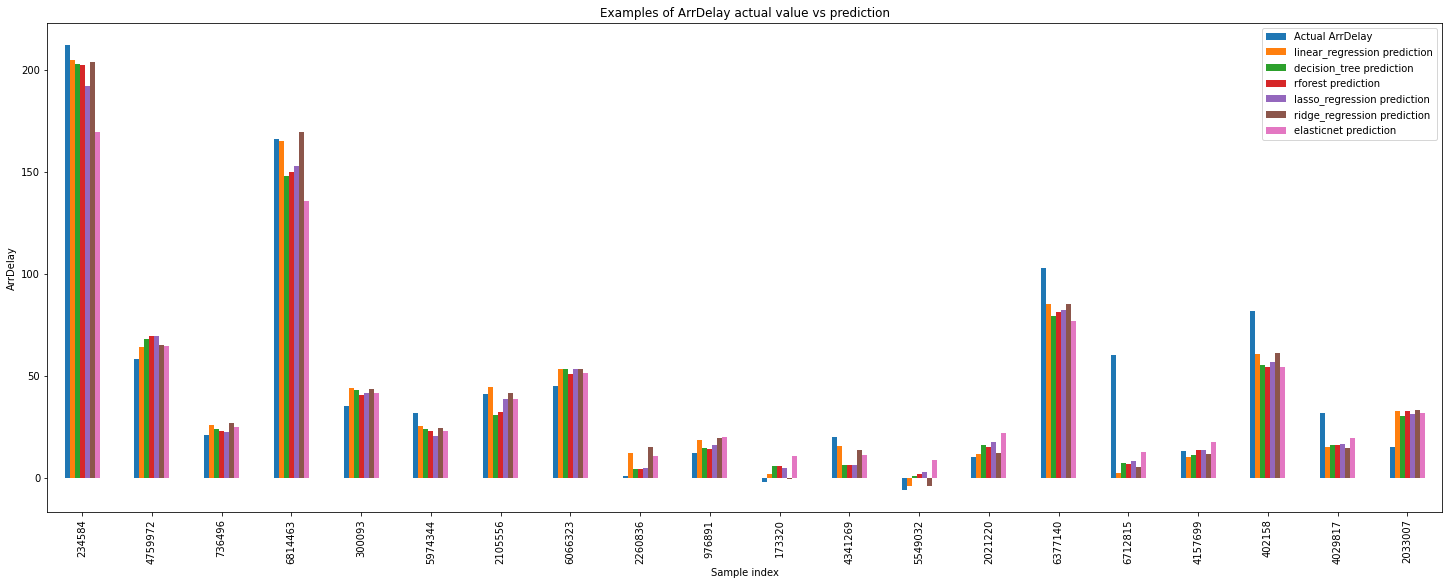

In [36]:
plot_predictions(models4, df_X_test4, df_y_test4, num_samples=20, random_state=None)

Si comparem amb els primers models entrenats anteriorment (models2), no s'observa una millora significativa.

## Exercici 6
No utilitzis la variable DepDelay a l’hora de fer prediccions.

In [61]:
models5 = clone(models2)

In [63]:
# We split the features in 2 groups, depending on the preprocessing to be performed
# At this moment we consider Month, Day, DayOfWeek as numerical features (not categorical)

# Categorical features
cat_columns5 = ['TailNum', 'UniqueCarrier', 'Dest', 'Origin']

# Numerical features (all the rest). Note: we removed 'DepDelay'
num_columns5 = ['Month', 'DayOfMonth', 'DayOfWeek', 'DepTime', 
               'CRSArrTime', 'CRSElapsedTime', 'Distance', 'TaxiOut']

features5 = cat_columns5 + num_columns5
target5 = ['ArrDelay']

print(f"Categorical columns are: {cat_columns5}")
print(f"Numerical columns are: {num_columns5}")

Categorical columns are: ['TailNum', 'UniqueCarrier', 'Dest', 'Origin']
Numerical columns are: ['Month', 'DayOfMonth', 'DayOfWeek', 'DepTime', 'CRSArrTime', 'CRSElapsedTime', 'Distance', 'TaxiOut']


In [64]:
# Preprocessing/Transformations steps for the pipelines

# Cache folder
cachedir5 = mkdtemp()

# Transformations for numerical features:
#   - StandardScaler()
num_pipe5 = Pipeline([('scaler', StandardScaler())],
                    memory=cachedir5)

# Transformations for categorical features
#   - One Hot Encoding
cat_pipe5 = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))],
                    memory=cachedir5)

# We combine both transformations
preprocessor5 = ColumnTransformer(transformers=[
                                               ('num_transf', num_pipe5, num_columns5),
                                               ('cat_transf', cat_pipe5, cat_columns5)
                                               ],
                                 verbose=False)

# For some models, the target needs to be a 1D array (not a 2D array).
# So we create this transformation to convert to 1D and we will use it when needed
reshape1D_transf = FunctionTransformer(np.ravel)


In [65]:
for model in models5:
  model.steps.pop(0);
  model.steps.insert(0,['preprocess5', preprocessor5])

In [66]:
df_X_train5, df_X_test5, df_y_train5, df_y_test5 = train_test_split(df[features5], df[target], test_size=0.3, random_state=RS, shuffle=True)

total_size5 = df.shape[0]
train_size5 = df_X_train5.shape[0]
test_size5 = df_X_test5.shape[0]

print(f'Total size of the dataset: {total_size} samples')
print(f'Size of the Training set: {train_size} samples ({100*train_size/total_size:.2f} %)')
print(f'Size of the Test set: {test_size} samples ({100*test_size/total_size:.2f} %)')



Total size of the dataset: 1928368 samples
Size of the Training set: 1349857 samples (70.00 %)
Size of the Test set: 578511 samples (30.00 %)


In [67]:
models5, indices_train5, _, _ = train_test_models(models5, 
                                                df_X_train5, df_y_train5, 
                                                df_X_test5, df_y_test5, 
                                                train_size=100_000, 
                                                verbose=True)

  0%|          | 0/6 [00:00<?, ?it/s]

Model: linear_regression. Training...Testing...Done!
Model: decision_tree. Training...Testing...Done!
Model: rforest. Training...Testing...Done!
Model: lasso_regression. Training...Testing...Done!
Model: ridge_regression. Training...Testing...Done!
Model: elasticnet. Training...Testing...Done!

---- Model TrainTesting (Summary) ----
Number of samples (from the training set) used: 100_000

Model                MSE (Train)    MSE (Test)  diff MSE      R2 (Train)    R2 (Test)  diff R2      Training Time [s]
-----------------  -------------  ------------  ----------  ------------  -----------  ---------  -------------------
linear_regression        2751.4        2988.84  7.9%           0.187559     0.0740785  -153.2%               5.99533
decision_tree            1628.02       1910.16  14.8%          0.519274     0.408245   -27.2%                1.99831
rforest                  1686.62       1857.12  9.2%           0.501971     0.424678   -18.2%               12.4428
lasso_regression      

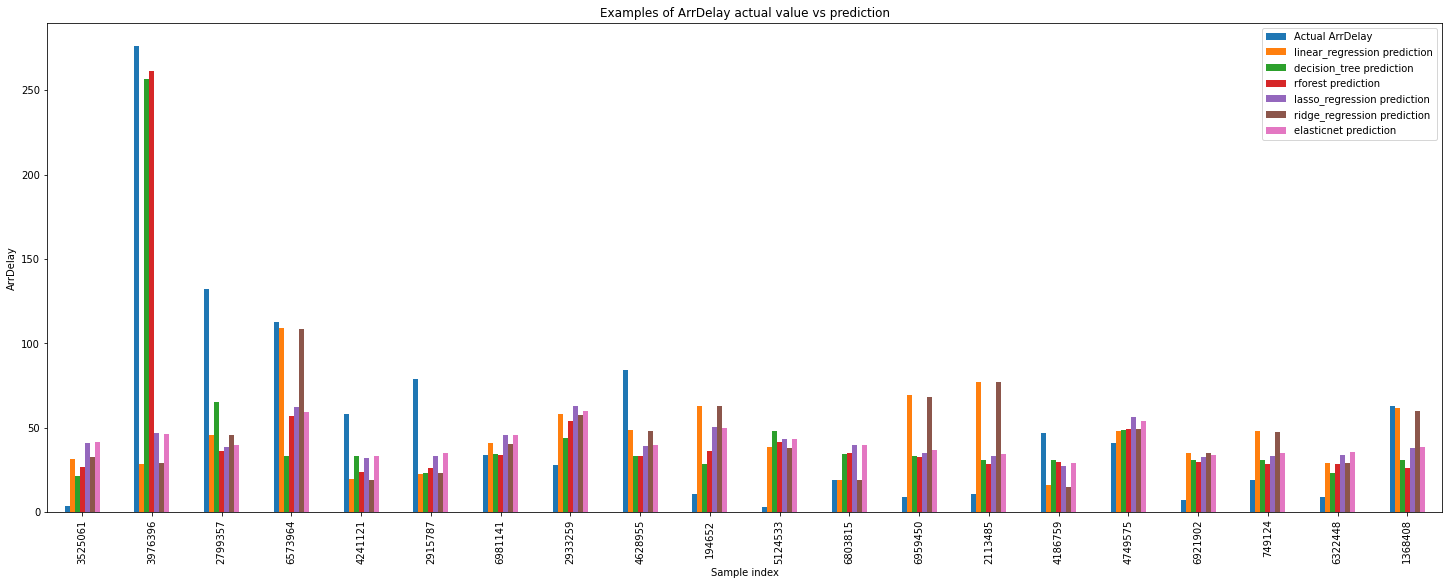

In [69]:
plot_predictions(models5, df_X_train5, df_y_train5, num_samples=20, random_state=None)

Veiem com amb els mateixos models amb els mateixos hiperparàmetres però entrenats sense la variable 'DepDelay' no s'obtenen bones prediccions. Es podria intentar millorar les prediccions ajustant els hiperparàmetres però ja es veu que no es podrà arribar a un resultat tant bo, ja que la variable DepDelay està fortament correlacionada amb el target ArrDelay. En effecte, té sentit pensar que un retard en la sortida té un fort impacte en el retard a l'arribada.